In [7]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [18]:
#definimos la operacion kernel como un kernel gaussiano

def rbf_kernel(X, Y, sigma=1.0):
    X = tf.cast(X,tf.float32)
    Y = tf.cast(Y,tf.float32)
    X_expanded = tf.expand_dims(X, axis=1)  # Shape: (batch_size, 1, latent_dim)
    Y_expanded = tf.expand_dims(Y, axis=0)  # Shape: (1, batch_size, latent_dim)
    squared_distance = tf.reduce_sum(tf.square(X_expanded - Y_expanded), axis=2)
    return tf.exp(-squared_distance / (2 * sigma ** 2))


In [20]:
#Debemos definir la funcion de costo
def COCO_loss(alpha,x_true,x_pred,y_true,y_pred,beta=1.0,eta=0.5,gamma=0.5):
    K=rbf_kernel(x_true,x_pred)
    L=rbf_kernel(y_true,y_pred)
    print(tf.shape(alpha),tf.shape(K),tf.shape(L))
    loss = (-tf.reduce_mean(alpha*K*L*beta))+((eta/2)*tf.reduce_sum(alpha*K*alpha)-1)+((gamma/2)*tf.reduce_sum(beta*L*beta)-1)
    return loss

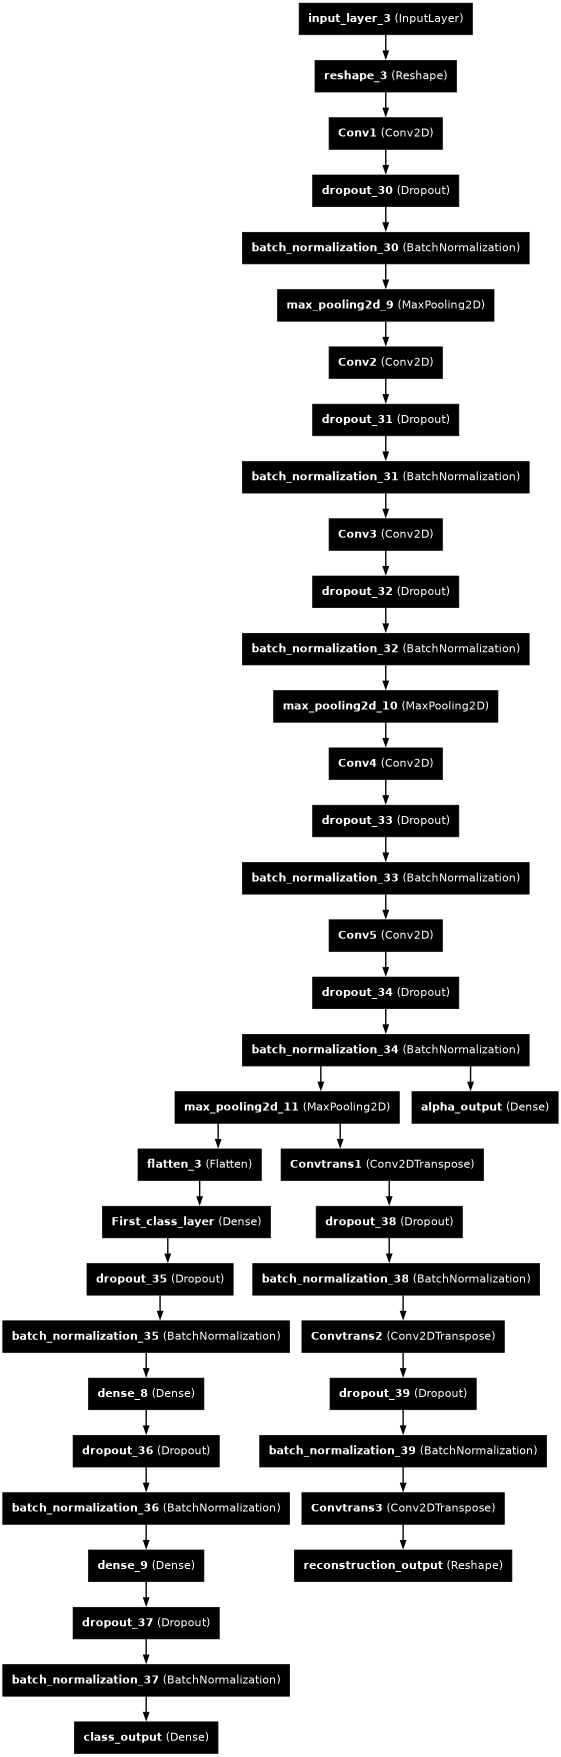

In [10]:
#Número de clases para clasificar y batch size
class_num=10

#Definimos una red que va a recosntruir y clasificar las imagenes de fashion mnist
#La primera sección se compone de las capas convolucionales que van a extraer las caracteristicas de las imagenes
input_layer = keras.layers.Input(shape=[28,28])
x = keras.layers.Reshape([28,28,1])(input_layer)
x = keras.layers.Conv2D(16, name="Conv1",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(32,name="Conv2", kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, name="Conv3",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(64, name="Conv4",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, name="Conv5",kernel_size=3, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
alpha = keras.layers.Dense(1,name="alpha_output",activation="relu")(x)
latent_space = keras.layers.MaxPool2D(pool_size=2)(x)
#A partir de este punto siguen las capas densas que utilizan las caracteristicas extraidas para definir a que clase
#pertenecen las imagenes
class_input = keras.layers.Flatten()(latent_space)
x = keras.layers.Dense(500,name="First_class_layer",activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(class_input)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(200,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(100,activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.04))(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.BatchNormalization()(x)
class_output = keras.layers.Dense(class_num,activation="softmax",name="class_output")(x)
#Tambien añadimos una seccion de reconstruccion para regularizar
decoder_input = keras.layers.Conv2DTranspose(32,name="Convtrans1", kernel_size=3, strides=2, padding="VALID", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(latent_space)
x = keras.layers.Dropout(rate=0.1)(decoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(16,name="Convtrans2", kernel_size=3, strides=2, padding="SAME", activation="relu",kernel_initializer="HeNormal",kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(rate=0.1)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2DTranspose(1,name="Convtrans3", kernel_size=3, strides=2, padding="SAME", activation="sigmoid")(x)
decoder_output = keras.layers.Reshape([28, 28],name="reconstruction_output")(x)

#Definimos el modelo usando la api funcional y lo compilamos, al final mostramos el resumen del modelo o un diagrama 
classifier = keras.Model(inputs=input_layer,outputs=[alpha,class_output,decoder_output])
#Creamos el objeto loss
#COCO = COCO_loss(alpha,x_true,x_pred,y_true,y_pred)#Posiblemente toque revisarlo o en un loop de entrenamiento custom, o con add_loss que no se como se
                                                #revisa
#classifier.compile(loss=["sparse_categorical_crossentropy","binary_crossentropy"],optimizer=keras.optimizers.Adam(0.0001),metrics=["sparse_categorical_accuracy","accuracy"])
tf.keras.utils.plot_model(classifier,show_layer_names=True,dpi=50)

In [11]:
def exp_decay_lr(initial_lr, decay_rate, epoch):
    return initial_lr * decay_rate ** epoch

In [21]:
# Custom training loop
#eta0 = 1e-1
batch_size = 64
epochs = 200
decay_rate = 0.95
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

#Listas para graficar las perdidas
t_loss_train=[]
CC_loss_train=[]
t_loss_val=[]
CC_loss_val=[]

with tf.device('/gpu:0'):
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        #eta = exp_decay_lr(eta0, decay_rate=decay_rate, epoch=epoch)
        for x_batch,y_batch in tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1024).batch(batch_size):
            alpha,y_pred,x_pred = classifier(x_batch,training=True)
            with tf.GradientTape() as g:
                g.watch(alpha)
                COCO_loss_ = COCO_loss(alpha,x_batch,x_pred,y_batch,y_pred)
                class_loss_ = tf.losses.SparceCategoricalCrossentropy(y_batch,y_pred)
                rec_loss_ = tf.losses.BinaryCrossentropy(x_batch,x_pred)
                total_loss_ = COCO_loss_+class_loss_+rec_loss_
            grad_ = g.gradient(total_loss, classifier.trainable_variables + [alpha])
            optimizer.apply_gradients(zip(grad_, classifier.trainable_variables+[alpha]))
            train_loss(total_loss)
            t_loss_train.append(train_loss)
            CC_loss_train.append(CC_loss_)
        for x_val,y_val in tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(buffer_size=1024).batch(batch_size):
            alpha,y_pred,x_pred = classifier(x_batch,training=False)
            COCO_loss_val = COCO_loss(alpha,x_val,x_pred,y_val,y_pred)
            class_loss_val = tf.losses.SparceCategoricalCrossentropy(y_val,y_pred)
            rec_loss_val = tf.losses.BinaryCrossentropy(x_val,x_pred)
            total_loss_val = COCO_loss_val+class_loss_val+rec_loss_val
            val_loss(total_loss_val)
            t_loss_val.append(val_loss)
            CC_loss_val.append(CC_loss_val)
        print(f'Epoch {epoch + 1}, '
          f'Loss: {train_loss.result()}, '
          f'Test Loss: {val_loss.result()}')


Epoch 1/200
tf.Tensor([64  7  7  1], shape=(4,), dtype=int32) tf.Tensor([64 64 28], shape=(3,), dtype=int32) tf.Tensor([ 1 64], shape=(2,), dtype=int32)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [64,7,7,1] vs. [64,64,28] [Op:Mul] name: 

In [ ]:
#Graficamos el loss de entrenamiento y validación
plt.plot(t_loss_train,label="Loss")
plt.plot(t_loss_val,label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

In [ ]:
#Graficamos el loss de entrenamiento y validación
plt.plot(CC_loss_train,label="COCO Loss")
plt.plot(CC_loss_val,label="COCO Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

In [ ]:
#Se entrena el modelo
history = classifier.fit(X_train,[y_train,X_train], batch,epochs=200,
                      validation_data=(X_valid,[y_valid,X_valid]))